# Predicting death in MIMIC3

## Data Loading

In [1]:
from numpy.random import seed
seed(2)

In [2]:
import pandas as pd
import numpy as np
from random import randint
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_fscore_support, classification_report

In [3]:
from keras.models import Model, Input, load_model, Sequential
from keras.layers import Masking, Flatten, Embedding, Dense, LSTM, TimeDistributed, Reshape, multiply, Permute
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.


In [4]:
pushd '../mimic/data_processed'

/Users/garethbooth/Documents/repo/thesis/mimic/data_processed


['~/Documents/repo/thesis/notebooks']

In [5]:
df = pd.read_csv('mimic_dataset_incomplete.csv')

In [6]:
popd

/Users/garethbooth/Documents/repo/thesis/notebooks
popd -> ~/Documents/repo/thesis/notebooks


In [7]:
# convert gender to 0 or 1
df['GENDER'] = (df['GENDER'] == 'M').astype(int)

In [8]:
def df_split(df, ratio=0.2):
    '''
    Given dataframe, split 20% of patients into a separate test dataframe.
    
    Return df_train, df_test
    '''
    num_hadms = len(df['HADM_ID'].unique())
    split = int(ratio * num_hadms)
    hadms = df['HADM_ID'].unique()[:split]
    
    return df[~df.HADM_ID.isin(hadms)], df[df.HADM_ID.isin(hadms)]

In [9]:
df_train, df_test = df_split(df)

In [10]:
# sanity check
df_test['HADM_ID'].isin(df_train['HADM_ID']).value_counts()

False    2844
Name: HADM_ID, dtype: int64

In [11]:
df_train['HADM_ID'].isin(df_test['HADM_ID']).value_counts()

False    12412
Name: HADM_ID, dtype: int64

In [12]:
X_cols = [
    "Creatinine", "HCO3", "HR", "Haemoglobin", "Platelet_count",
    "Potassium", "RR", "Sodium", "AGE", "GENDER",
    'Chronic Kidney Disease', 'Obesity', 'Heart disease', 'Asthma', #comorbidities
    'Weight_kg', 'SaO2'
]

In [13]:
def create_tensors(df, maxshape=(0,0)):
    '''
    Split dataframe into X and Y tensors.

    Return X, Y
    '''
    hadms = df['HADM_ID'].unique()
    
    lst = []
    lst_y = []
    
    for hadm in hadms:
        point = df[df.HADM_ID == hadm][X_cols]
        maxshape = max(maxshape, point.values.shape)
        lst.append(point.values)
        lst_y.append(df[df.HADM_ID == hadm]['DEATH'].iloc[0])
    
#     maxshape = (1, 10)
    
    # pad to max shape to create tensor
    ret = np.zeros((len(lst), *maxshape))
    
    ret_y = np.array(lst_y)
    
    for index, l in enumerate(lst):
        x, y = min(maxshape[0], l.shape[0]), l.shape[1]

        ret[index, :x, :y] = l[:x, :y]

    return lst, ret, ret_y

In [14]:
lst_train, X_train, Y_train = create_tensors(df_train)
lst_test, X_test, Y_test = create_tensors(df_test)

In [15]:
X_train.shape

(2312, 63, 16)

## Dataset

### Histogram of Days

Don't cut to 14 days - want last day data before death for now

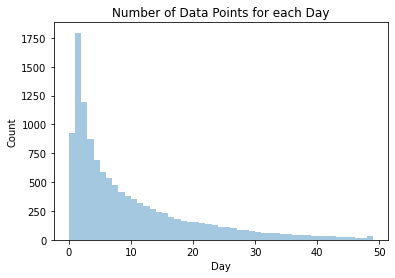

In [16]:
fig = sns.distplot(df_train[df_train.Day < 50]['Day'], bins=range(50), kde=False)
plt.title('Number of Data Points for each Day')
plt.ylabel('Count')
plt.show(fig)

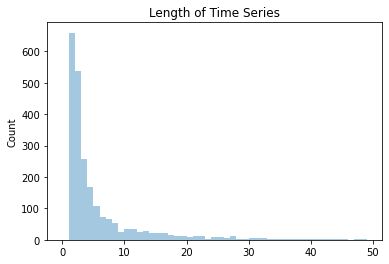

In [17]:
fig = sns.distplot([len(x) for x in lst_train if len(x) <= 50], bins=range(50), kde=False)
plt.title('Length of Time Series')
plt.ylabel('Count')
plt.show(fig)

In [18]:
# summary statistics
df_train['Day'].describe()

count    12412.000000
mean        10.494521
std         13.320318
min          0.000000
25%          2.000000
50%          6.000000
75%         14.000000
max        131.000000
Name: Day, dtype: float64

In [19]:
# number of patients who died
df_train.groupby('HADM_ID').first()['DEATH'].value_counts()

0    1576
1     736
Name: DEATH, dtype: int64

In [20]:
# number of patients who died
1 - sum(Y_test) / len(Y_test)

0.707105719237435

In [21]:
# class weights
class_weight = {0: 1, 1: 2}

### Histogram of Outcomes for Age

In [22]:
def plot_feature(col):
    died = []
    discharged = []

    for index, point in enumerate(lst_train):        
        if Y_train[index]:
            died.append(point[0, X_cols.index(col)])
        else:
            discharged.append(point[0, X_cols.index(col)])

    minimum = int(min(*died,*discharged))
    maximum = int(max(*died,*discharged))
    
    if minimum == 0 and maximum == 1:
        return
            
    sns.distplot(discharged, kde=False, bins=range(minimum, maximum), label="Discharged")
    fig = sns.distplot(died, kde=False, bins=range(minimum, maximum), label="Died")
    plt.title(f'Histogram for {col.title()}')
    plt.ylabel('Count')
    plt.xlabel(str(col.title()))
    plt.legend()
    plt.show(fig)

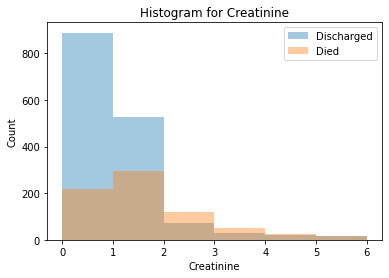

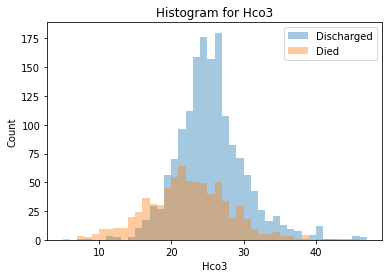

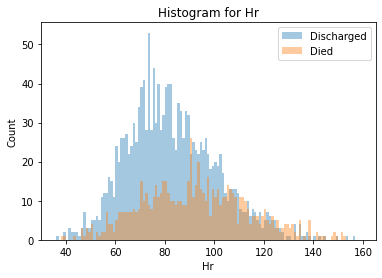

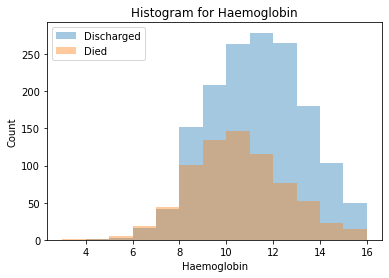

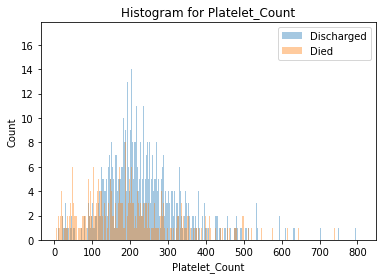

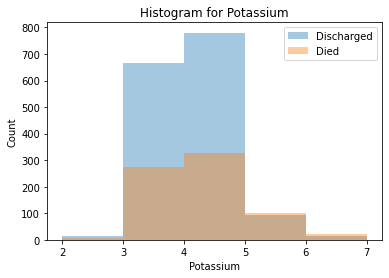

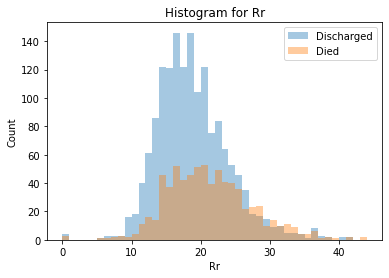

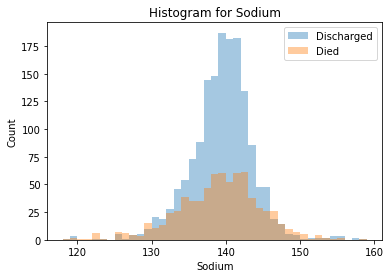

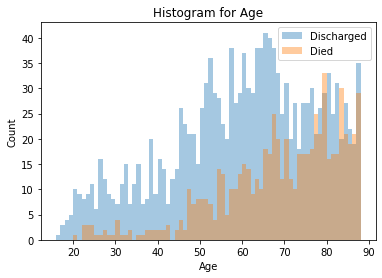

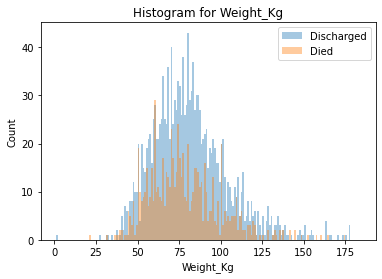

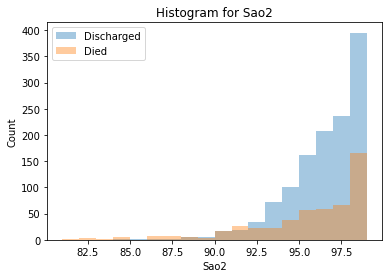

In [23]:
for col in X_cols:
    plot_feature(col)

### Histogram of Outcomes for each day

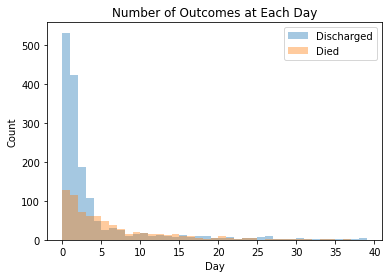

In [24]:
died = []
discharged = []

for index, point in enumerate(lst_train):
    if len(point) - 1 > 40:
        continue
        
    if Y_train[index]:
        died.append(len(point) - 1)
    else:
        discharged.append(len(point) - 1)
    
sns.distplot(discharged, kde=False, bins=range(40), label="Discharged")
fig = sns.distplot(died, kde=False, bins=range(40), label="Died")
plt.title('Number of Outcomes at Each Day')
plt.ylabel('Count')
plt.xlabel('Day')
plt.legend()
plt.show(fig)

### Correlation matrix

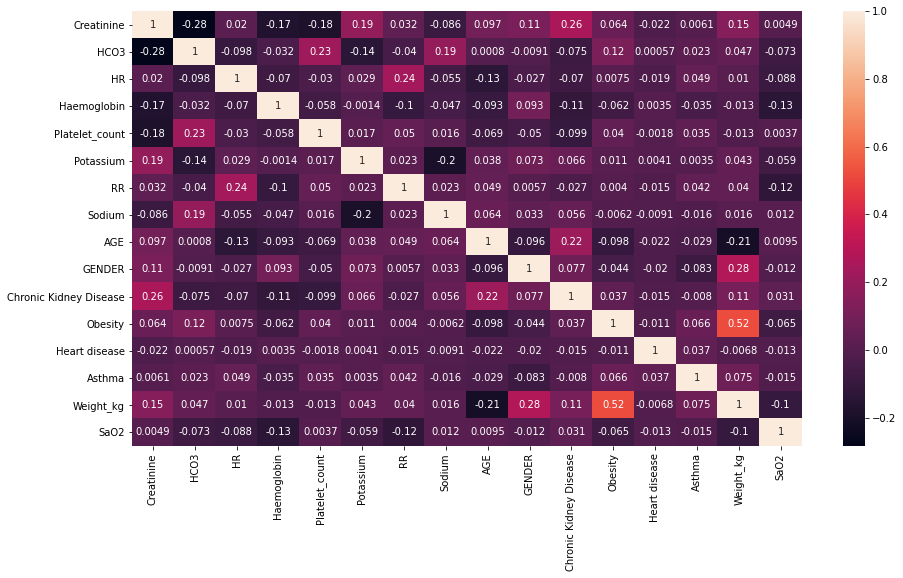

In [25]:
corrMatrix = df[X_cols].corr()

plt.figure(figsize=(15,8))
sns.heatmap(corrMatrix, annot=True)

### Create Model

Why 128 units?
Hypermarater search?
TODO

In [26]:
# input_layer = Input(shape=X_train.shape[1:]) 

# x = Permute((2,1))(input_layer)
# x = Dense(X_train.shape[1])(x)
# x = Permute((2,1))(x)

# # weight input with attention
# x = multiply([input_layer, x])
# x = Masking(mask_value=0)(x)

input_layer = Input(shape=(None, len(X_cols))) 

x = Masking(mask_value=0)(input_layer)
x = LSTM(128)(x) # units - dimensionality of output space
# x=attention()(x)
x = Dense(1, activation='sigmoid')(x) # binary output
model = Model(inputs=input_layer, outputs=x)

In [27]:
model.summary()

optimizer = Adam(lr=0.0005, epsilon=1e-08)
model.compile(optimizer, loss='binary_crossentropy', metrics=['acc'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 16)          0         
_________________________________________________________________
masking_1 (Masking)          (None, None, 16)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               74240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 74,369
Trainable params: 74,369
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.evaluate(x=X_train, y=Y_train)

2312/2312 [==============================] - 1s 310us/step


[0.6532275088930625, 0.6557093262672424]

In [29]:
model.fit(x=X_train, y=Y_train, class_weight=class_weight, epochs=50)

Epoch 1/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.7905 - acc: 0.7223
Epoch 2/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.7225 - acc: 0.7522
Epoch 3/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6858 - acc: 0.7647
Epoch 4/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6668 - acc: 0.7829
Epoch 5/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6479 - acc: 0.7833
Epoch 6/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6408 - acc: 0.7920
Epoch 7/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6371 - acc: 0.7898
Epoch 8/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6295 - acc: 0.7954
Epoch 9/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6206 - acc: 0.7993
Epoch 10/50
2312/2312 [==============================] - 3s 1ms/step - loss: 0.6135 - acc: 0.7967
Epoch 11/50
2312/2312 [======

In [30]:
model.evaluate(x=X_train, y=Y_train)

2312/2312 [==============================] - 1s 306us/step


[0.34942369498183573, 0.8615916967391968]

In [31]:
model.evaluate(x=X_test, y=Y_test)

577/577 [==============================] - 0s 248us/step


[0.3447860456628651, 0.8717504143714905]

In [32]:
# AUC
res = model.predict(x=X_test)[:,0]
argsort = np.argsort(res)

print(classification_report(Y_test[argsort], np.rint(res[argsort]).astype(int)))

roc_auc_score(Y_test[argsort], res[argsort])

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       408
           1       0.80      0.75      0.77       169

    accuracy                           0.87       577
   macro avg       0.85      0.84      0.84       577
weighted avg       0.87      0.87      0.87       577



0.91238832811231

how good is it?:
compare random forest with only admission data
can also do LSTM for this

## Missclassified results

In [33]:
argsort = np.argsort(Y_test)
Y_test[argsort[::-1]]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [34]:
preds = model.predict(x=X_test)
np.rint(preds).astype(int)[:,0][argsort[::-1]]

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

# Plot accuracy vs increasing sequence length (from 0)

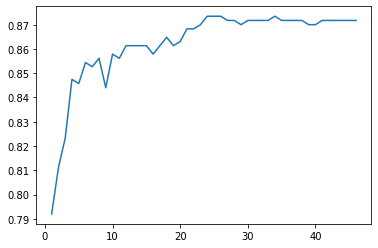

In [35]:
maxseqlen_test = max(len(lst) for lst in lst_test)
x = list(range(1,maxseqlen_test))
y = [model.evaluate(x=X_test[:,:a,:], y=Y_test, verbose=False)[1] for a in x]

sns.lineplot(x=x, y=y)

# Plot accuracy vs increasing sequence length (from end)

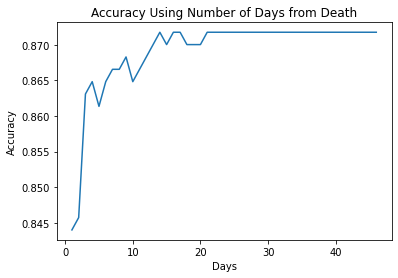

In [36]:
x = list(range(1,maxseqlen_test))
y = []

arr = np.zeros(X_test.shape)

for length in x:
    
    for index, point in enumerate(lst_test):
        r = np.array(point[::-1][:length][::-1])
        arr[index, :r.shape[0], :X_test.shape[2]] = r

    y.append(model.evaluate(x=arr, y=Y_test, verbose=False)[1])
    
fig = sns.lineplot(x=x, y=y)
plt.title('Accuracy Using Number of Days from Death')
plt.ylabel('Accuracy')
plt.xlabel('Days')
plt.show(fig)

# Sequence evolution


### Entire sequence

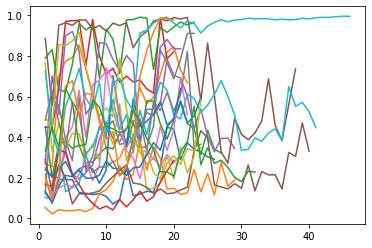

In [37]:
# Plot correctly classified sequences and ho
for index in range(len(lst_test)):
    x = range(1, len(lst_test[index]))
    y = []
    
    if len(x) < 20:
        continue

    for i in x:
        y.append(model.predict(x=np.array([lst_test[index][:i]]))[0][0])
        
    correct = Y_test[index] == round(y[-1])
    
    if correct:
        line = sns.lineplot(x=x, y=y)

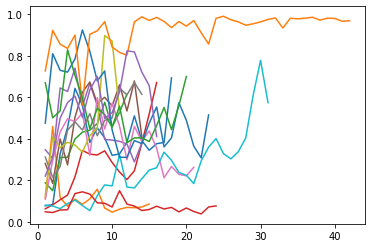

In [38]:
for index in range(len(lst_test)):
    x = range(1, len(lst_test[index]))
    y = []
    
    if len(x) < 10:
        continue

    for i in x:
        y.append(model.predict(x=np.array([lst_test[index][:i]]))[0][0])
        
    correct = Y_test[index] == round(y[-1])

    if not correct:
        line = sns.lineplot(x=x, y=y)

### Only last element

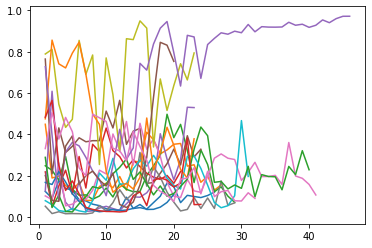

In [39]:
# Plot correctly classified sequences and ho
for index in range(len(lst_test)):
    x = range(1, len(lst_test[index]))
    y = []
    
    if len(x) < 20:
        continue

    for i in x:
        y.append(model.predict(x=np.array([lst_test[index][i-1:i]]))[0][0])
        
    correct = Y_test[index] == round(y[-1])
    
    if correct:
        line = sns.lineplot(x=x, y=y)

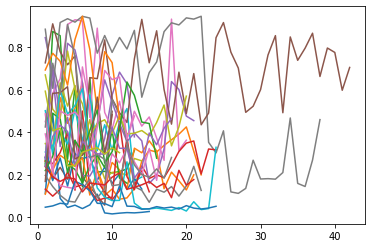

In [40]:
for index in range(len(lst_test)):
    x = range(1, len(lst_test[index]))
    y = []
    
    if len(x) < 10:
        continue

    for i in x:
        y.append(model.predict(x=np.array([lst_test[index][i-1:i]]))[0][0])
        
    correct = Y_test[index] == round(y[-1])

    if not correct:
        line = sns.lineplot(x=x, y=y)

# Misclassified stats

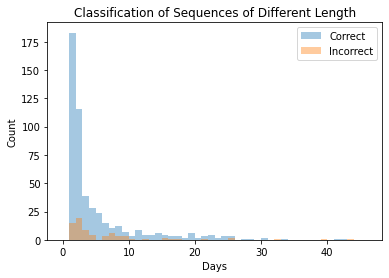

In [41]:
correct = []
incorrect = []

for index in range(len(lst_test)):
    result = model.predict(x=np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        correct.append(len(lst_test[index]))
    else:
        incorrect.append(len(lst_test[index]))

sns.distplot(correct, kde=False, bins=range(max(*correct, *incorrect)), label="Correct")
fig = sns.distplot(incorrect, kde=False, bins=range(max(*correct, *incorrect)), label="Incorrect")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

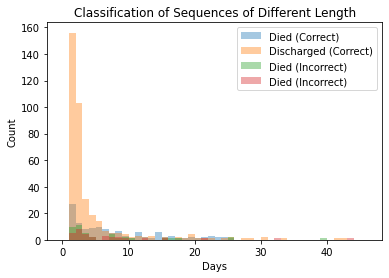

In [42]:
correct = {'Died':[], 'Discharged':[]}
incorrect = {'Died':[], 'Discharged':[]}

for index in range(len(lst_test)):
    result = model.predict(x=np.array([lst_test[index]]))[0][0]

    if Y_test[index] == round(result):
        if Y_test[index] == 0:
            correct['Discharged'].append(len(lst_test[index]))
        else:
            correct['Died'].append(len(lst_test[index]))
    else:
        if Y_test[index] == 0:
            incorrect['Discharged'].append(len(lst_test[index]))
        else:
            incorrect['Died'].append(len(lst_test[index]))
            
bins = range(max([y for x in list(correct.values()) + list(incorrect.values()) for y in x]))
            
sns.distplot(correct['Died'], kde=False, bins=bins, label="Died (Correct)")
sns.distplot(correct['Discharged'], kde=False, bins=bins, label="Discharged (Correct)")
sns.distplot(incorrect['Died'], kde=False, bins=bins, label="Died (Incorrect)")
fig = sns.distplot(incorrect['Discharged'], kde=False, bins=bins, label="Died (Incorrect)")
plt.legend()
plt.title('Classification of Sequences of Different Length')
plt.ylabel('Count')
plt.xlabel('Days')
plt.legend()
plt.show(fig)

In [43]:
..

SyntaxError: invalid syntax (<ipython-input-43-3d80792ead7e>, line 1)

In [44]:
# optional - save model
model.save_weights('saved_models/BinaryDeath_random_875', overwrite=False)

In [ ]:
# optional - save model
model.load_weights('BinaryDeath_random')

interesting thought - mask individual features?

should add comorbidities

# SHAP

In [ ]:
import myshap.shap as shap
# %load_ext autoreload
# %autoreload 2
shap.initjs()

In [ ]:
def predict(X):
    # use all daily data as if they're completely independent.
    X = X.reshape((-1,1,len(X_cols)))
    return model.predict(X).flatten()

In [ ]:
all_data_summary = shap.kmeans(df_test[X_cols], 10)

In [ ]:
input_data = df_test[X_cols]
explainer = shap.KernelExplainer(predict, all_data_summary)
shap_values = explainer.shap_values(input_data)

In [ ]:
shap.summary_plot(shap_values, input_data)

In [ ]:
shap.dependence_plot('AGE', shap_values, features=input_data, interaction_index='HCO3')

In [ ]:
shap.dependence_plot('RR', shap_values, features=input_data, interaction_index='HR')

In [ ]:
shap.dependence_plot('HR', shap_values, features=input_data, interaction_index='RR')

In [ ]:
seq = [0] + list(map(len, lst_test))
for i in range(len(seq)):
    if i != 0:
        seq[i] += seq[i-1]

longest_sequences_index = list(reversed(np.argsort([len(x) for x in lst_test])))

In [ ]:
index = longest_sequences_index[18]
sl = slice(seq[index], seq[index+1])
print(f"Sequence length: {seq[index+1] - seq[index]}")
print(f"Predicted {preds[index,0]}, Actual {Y_test[index]}")
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [ ]:
index = 8
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [ ]:
index = 12
sl = slice(index, index+1)
shap.force_plot(explainer.expected_value, shap_values[sl], input_data[sl])

In [ ]:
shap.force_plot(explainer.expected_value, shap_values, input_data)

In [ ]:
shap.summary_plot(shap_values, input_data, max_display=14, plot_type='violin', feature_names=X_cols)

In [ ]:
import matplotlib.pyplot as pl
from myshap.shap.plots import colors 

pl.scatter(input_data['HR'], input_data['RR'], s=3,
           c=shap_values[:, X_cols.index('HR')], cmap=colors.red_blue)